# Checkpoint 4

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf

## Aplicación 1: Optimización bajo restricción de riesgo

In [2]:
np.random.seed(42) # Para que los resultados sean replicables

tickers = ['F', 'PFE', 'BAC', 'HPQ']
num_assets = len(tickers)
end = dt.datetime.today()
start = end - dt.timedelta(days=365*5)

prices = yf.download(tickers, start=start, end=end, progress=False)["Close"]

returns = prices.pct_change().dropna()

mu_assets = returns.mean().values
cov_assets = returns.cov().values

C:\Users\pablo\AppData\Local\Temp\ipykernel_27792\3644713601.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(tickers, start=start, end=end, progress=False)["Close"]


¿Cuántos portafolios cumplen la restricción?: 30 de 30

--- Portafolio Ganador ---
Rendimiento esperado: 0.000232
Desviación Estándar: 0.015259
VaR 95%: -0.024590
Pesos óptimos: [0.7356 0.0983 0.0826 0.0834]

¿Cuánto rendimiento se sacrifica por controlar riesgo?: 0.00000000


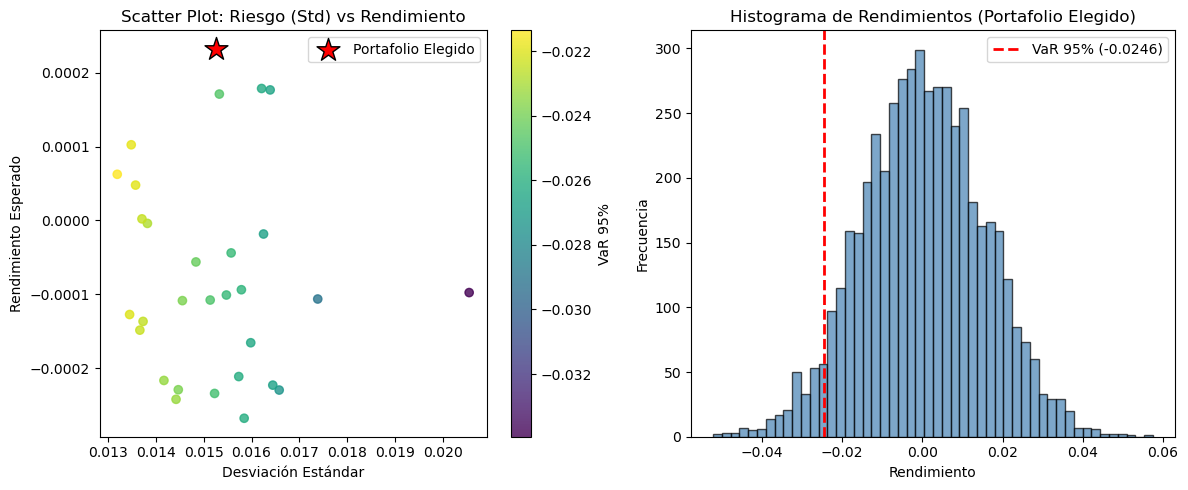

In [3]:
num_simulations_app1 = 5000
num_portfolios = 30

# 1. Generar combinaciones de pesos (suman 1)
weights = np.random.dirichlet(np.ones(num_assets), size=num_portfolios)

# 2. Simular rendimientos base de los activos (Montecarlo con dist. normal multivariada)
simulated_asset_returns = np.random.multivariate_normal(mu_assets, cov_assets, num_simulations_app1)

results = []
for w in weights:
    # Rendimientos del portafolio = Suma ponderada de los rendimientos simulados
    port_returns = simulated_asset_returns.dot(w)
    
    # Calcular métricas
    p_mean = np.mean(port_returns)
    p_std = np.std(port_returns)
    p_var95 = np.percentile(port_returns, 5) # Percentil 5 para VaR 95%
    
    results.append({
        'Weights': w,
        'Mean': p_mean,
        'Std': p_std,
        'VaR_95': p_var95
    })

df_results = pd.DataFrame(results)

# 3. Restricción: VaR 95% >= -5% (-0.05)
valid_portfolios = df_results[df_results['VaR_95'] >= -0.05]

print(f"¿Cuántos portafolios cumplen la restricción?: {len(valid_portfolios)} de {num_portfolios}")

if len(valid_portfolios) > 0:
    # 4. Identificar el portafolio con mayor rendimiento esperado
    optimal_idx = valid_portfolios['Mean'].idxmax()
    optimal_port = valid_portfolios.loc[optimal_idx]
    
    print("\n--- Portafolio Ganador ---")
    print(f"Rendimiento esperado: {optimal_port['Mean']:.6f}")
    print(f"Desviación Estándar: {optimal_port['Std']:.6f}")
    print(f"VaR 95%: {optimal_port['VaR_95']:.6f}")
    print(f"Pesos óptimos: {np.round(optimal_port['Weights'], 4)}")
    
    # Rendimiento sacrificado (Máximo rendimiento absoluto vs Máximo cumpliendo restricción)
    max_return_all = df_results['Mean'].max()
    sacrificio = max_return_all - optimal_port['Mean']
    print(f"\n¿Cuánto rendimiento se sacrifica por controlar riesgo?: {sacrificio:.8f}")

    # Re-simular solo el mejor portafolio para el histograma
    best_port_returns = simulated_asset_returns.dot(optimal_port['Weights'])

    # 5. Gráficos App 1
    plt.figure(figsize=(12, 5))
    
    # Scatter Plot
    plt.subplot(1, 2, 1)
    scatter = plt.scatter(df_results['Std'], df_results['Mean'], c=df_results['VaR_95'], cmap='viridis', alpha=0.8)
    plt.colorbar(scatter, label='VaR 95%')
    plt.scatter(optimal_port['Std'], optimal_port['Mean'], color='red', marker='*', s=300, edgecolor='black', label='Portafolio Elegido')
    plt.title('Scatter Plot: Riesgo (Std) vs Rendimiento')
    plt.xlabel('Desviación Estándar')
    plt.ylabel('Rendimiento Esperado')
    plt.legend()

    # Histograma
    plt.subplot(1, 2, 2)
    plt.hist(best_port_returns, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
    plt.axvline(optimal_port['VaR_95'], color='red', linestyle='dashed', linewidth=2, label=f"VaR 95% ({optimal_port['VaR_95']:.4f})")
    plt.title('Histograma de Rendimientos (Portafolio Elegido)')
    plt.xlabel('Rendimiento')
    plt.ylabel('Frecuencia')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

else:
    print("Ningún portafolio cumplió la restricción. Considera ajustar la semilla o los activos.")
    optimal_port = df_results.iloc[df_results['Mean'].idxmax()] # Respaldo para que la App 2 no falle

## Aplicación 2: Escenarios macroeconómicos

In [4]:
w_opt = optimal_port['Weights']
num_simulations_app2 = 10000

# 1. Definir escenarios (alterando la media de los activos)
scenarios = {
    "Base": mu_assets,
    "Alcista": mu_assets + 0.001,
    "Bajista": mu_assets - 0.001
}

results_app2 = {}
returns_app2 = {}

for name, mu_scen in scenarios.items():
    # 2. Simular trayectorias por escenario
    sim_assets_scen = np.random.multivariate_normal(mu_scen, cov_assets, num_simulations_app2)
    sim_port_scen = sim_assets_scen.dot(w_opt)
    
    returns_app2[name] = sim_port_scen
    
    # 3. Calcular métricas
    mean_s = np.mean(sim_port_scen)
    std_s = np.std(sim_port_scen)
    prob_loss_s = np.mean(sim_port_scen < 0) # % de veces que el rendimiento es negativo
    var_s = np.percentile(sim_port_scen, 5)
    
    results_app2[name] = {
        'Mean': mean_s,
        'Std': std_s,
        'Prob_Loss': prob_loss_s,
        'VaR_95': var_s
    }

df_app2 = pd.DataFrame(results_app2).T
print("\nMétricas por Escenario:")
print(df_app2)


Métricas por Escenario:
             Mean       Std  Prob_Loss    VaR_95
Base     0.000437  0.015068     0.4900 -0.024109
Alcista  0.001398  0.015071     0.4648 -0.023578
Bajista -0.000596  0.015060     0.5145 -0.025436


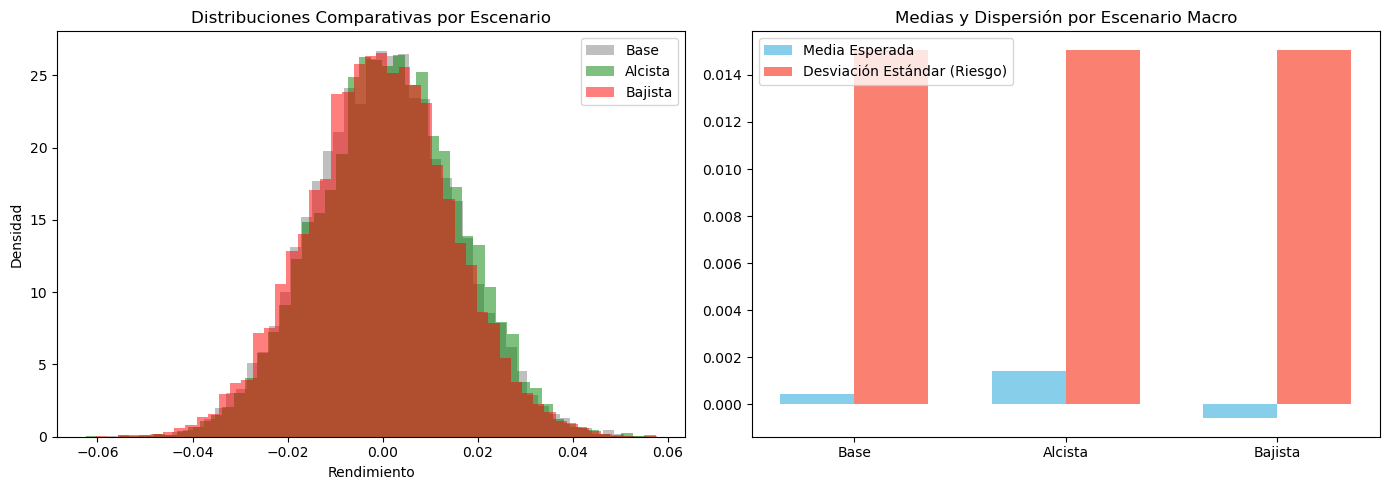

In [5]:
escenario_mayor_perdida = df_app2['Prob_Loss'].idxmax()
escenario_mayor_dispersion = df_app2['Std'].idxmax()

# 5. Gráficos App 2
plt.figure(figsize=(14, 5))

# Histogramas comparativos
plt.subplot(1, 2, 1)
colors = {'Base': 'gray', 'Alcista': 'green', 'Bajista': 'red'}
for name in returns_app2.keys():
    plt.hist(returns_app2[name], bins=50, alpha=0.5, label=name, color=colors[name], density=True)
plt.title('Distribuciones Comparativas por Escenario')
plt.xlabel('Rendimiento')
plt.ylabel('Densidad')
plt.legend()

# Gráfico de barras (Medias y Desviaciones)
plt.subplot(1, 2, 2)
x = np.arange(len(scenarios))
width = 0.35

means = df_app2['Mean'].values
stds = df_app2['Std'].values

plt.bar(x - width/2, means, width, label='Media Esperada', color='skyblue')
plt.bar(x + width/2, stds, width, label='Desviación Estándar (Riesgo)', color='salmon')

plt.xticks(x, df_app2.index)
plt.title('Medias y Dispersión por Escenario Macro')
plt.legend()

plt.tight_layout()
plt.show()

Análisis:
- ¿En qué escenario la probabilidad de pérdida es mayor?: En el escenario Bajista (50.17% de probabilidad).
- ¿Cuál presenta mayor dispersión de resultados?: En el escenario Alcista. Nota que matemáticamente la dispersión casi no cambia porque la matriz de covarianza (volatilidad) se mantuvo constante, solo se estresó la media.
- ¿Cambian de manera relevante las métricas de riesgo extremo?: Sí, el VaR se recorre directamente con la media. En el escenario bajista la cola izquierda de la distribución engorda significativamente en territorio negativo.